In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pybamm
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

print(pybamm.__version__)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

24.9.0


In [2]:
temperature_C_candi = [15,25,35]
current_C_candi = [0.5,1.5]

In [3]:
model = pybamm.equivalent_circuit.Thevenin(options={"operating mode":"current","number of rc elements":0})

import os
params = model.default_parameter_values
path = os.getcwd()
ocv_data = pybamm.parameters.process_1D_data("ecm_ocv.csv", path=path)
r0_data = pybamm.parameters.process_3D_data_csv("ecm_r0.csv", path=path)

def r0(T_cell, current, soc):
    name, (x, y) = r0_data
    return pybamm.Interpolant(x, y, [T_cell, current, soc], name)


def discharge_st_index(arr):
    for i in range(len(arr)):
        if arr[i] > 0:
            return i
    return None  # current가 양수될 때 (discharge 시작)

def charge_ed_index(arr):
    for i in range(len(arr)):
        if abs(arr[i]-4.2)<1e-6:
            return i
    return None

In [4]:
params.update(
    {   "Upper voltage cut-off [V]":4.2,
        "Jig thermal mass [J/K]": 1e10,
        "Jig-air heat transfer coefficient [W/K]": 0,            
        "Cell capacity [A.h]": 5,
        "Nominal cell capacity [A.h]": 5,
        "Initial SoC": 0,
        "Lower voltage cut-off [V]": 3.0,
        "Open-circuit voltage [V]": ocv_data,
        "Entropic change [V/K]": 0, 
        "Voltage function [V]": 4.2,
        "R0 [Ohm]": r0,
    }, check_already_exists=False
)

solver = pybamm.CasadiSolver(mode='safe',return_solution_if_failed_early=True)

In [5]:
def rmse_cal_ch_dch(ecm_voltage_ch,ecm_voltage_dch,sol,x,y,ch_ed_idx,dch_st_idx):
    x_exp_ch = ecm_voltage_ch[x].values # x values of experimental data
    y_exp_ch = ecm_voltage_ch[y].values # y values of experimental data
    x_model_ch = sol[x].entries[:ch_ed_idx+1]
    y_model_ch = sol[y].entries[:ch_ed_idx+1] 
    if x_exp_ch[-1] > x_model_ch[-1]:
        for i in range(len(x_exp_ch)):
            if x_exp_ch[::-1][i] > x_model_ch[-1]:
                remove_idx = i
        x_exp_ch = x_exp_ch[:-(remove_idx+1)]
        y_exp_ch = y_exp_ch[:-(remove_idx+1)]    
    # Interpolate model data to match experimental x values
    interp_model = interp1d(x_model_ch, y_model_ch, kind='linear', fill_value="extrapolate")
    y_model_interp_ch = interp_model(x_exp_ch)  # Interpolated model values at experimental x values  

    # Example experimental data (x_exp and y_exp are discrete experimental data points)
    x_exp_dch = ecm_voltage_dch[x].values # x values of experimental data
    y_exp_dch = ecm_voltage_dch[y].values # y values of experimental data
    x_model_dch = sol[x].entries[dch_st_idx:]
    y_model_dch = sol[y].entries[dch_st_idx:] 
    if x_exp_dch[-1] > x_model_dch[-1]:
        for i in range(len(x_exp_dch)):
            if x_exp_dch[::-1][i] > x_model_dch[-1]:
                remove_idx = i
        x_exp_dch = x_exp_dch[:-(remove_idx+1)]
        y_exp_dch = y_exp_dch[:-(remove_idx+1)]   
    # Interpolate model data to match experimental x values
    interp_model = interp1d(x_model_dch, y_model_dch, kind='linear', fill_value="extrapolate")
    y_model_interp_dch = interp_model(x_exp_dch)  # Interpolated model values at experimental x values          

    y_exp = np.concatenate([y_exp_ch,y_exp_dch])
    y_model_interp = np.concatenate([y_model_interp_ch,y_model_interp_dch])
    rmse = np.sqrt(mean_squared_error(y_exp, y_model_interp))
    return rmse

def rmse_cal(ecm_voltage,sol,x,y):
        
    x_exp = ecm_voltage[x].values # x values of experimental data
    y_exp = ecm_voltage[y].values # y values of experimental data
    x_model = sol[x].entries
    y_model = sol[y].entries
    if x_exp[-1] > x_model[-1]:
        for i in range(len(x_exp)):
            if x_exp[::-1][i] > x_model[-1]:
                remove_idx = i
        x_exp = x_exp[:-(remove_idx+1)]
        y_exp = y_exp[:-(remove_idx+1)]    
    # Interpolate model data to match experimental x values
    interp_model = interp1d(x_model, y_model, kind='linear', fill_value="extrapolate")
    y_model_interp = interp_model(x_exp)  # Interpolated model values at experimental x values  
 
    rmse = np.sqrt(mean_squared_error(y_exp, y_model_interp))
    return rmse

0.5 15
0.10826006469483353 0.009600114126891525 0.0017078857812571136
0.5 25
0.08815663470001044 0.009751169380255689 0.0011757286334804612
0.5 35
0.0741774778979326 0.015917781762624397 0.0007441322139701427


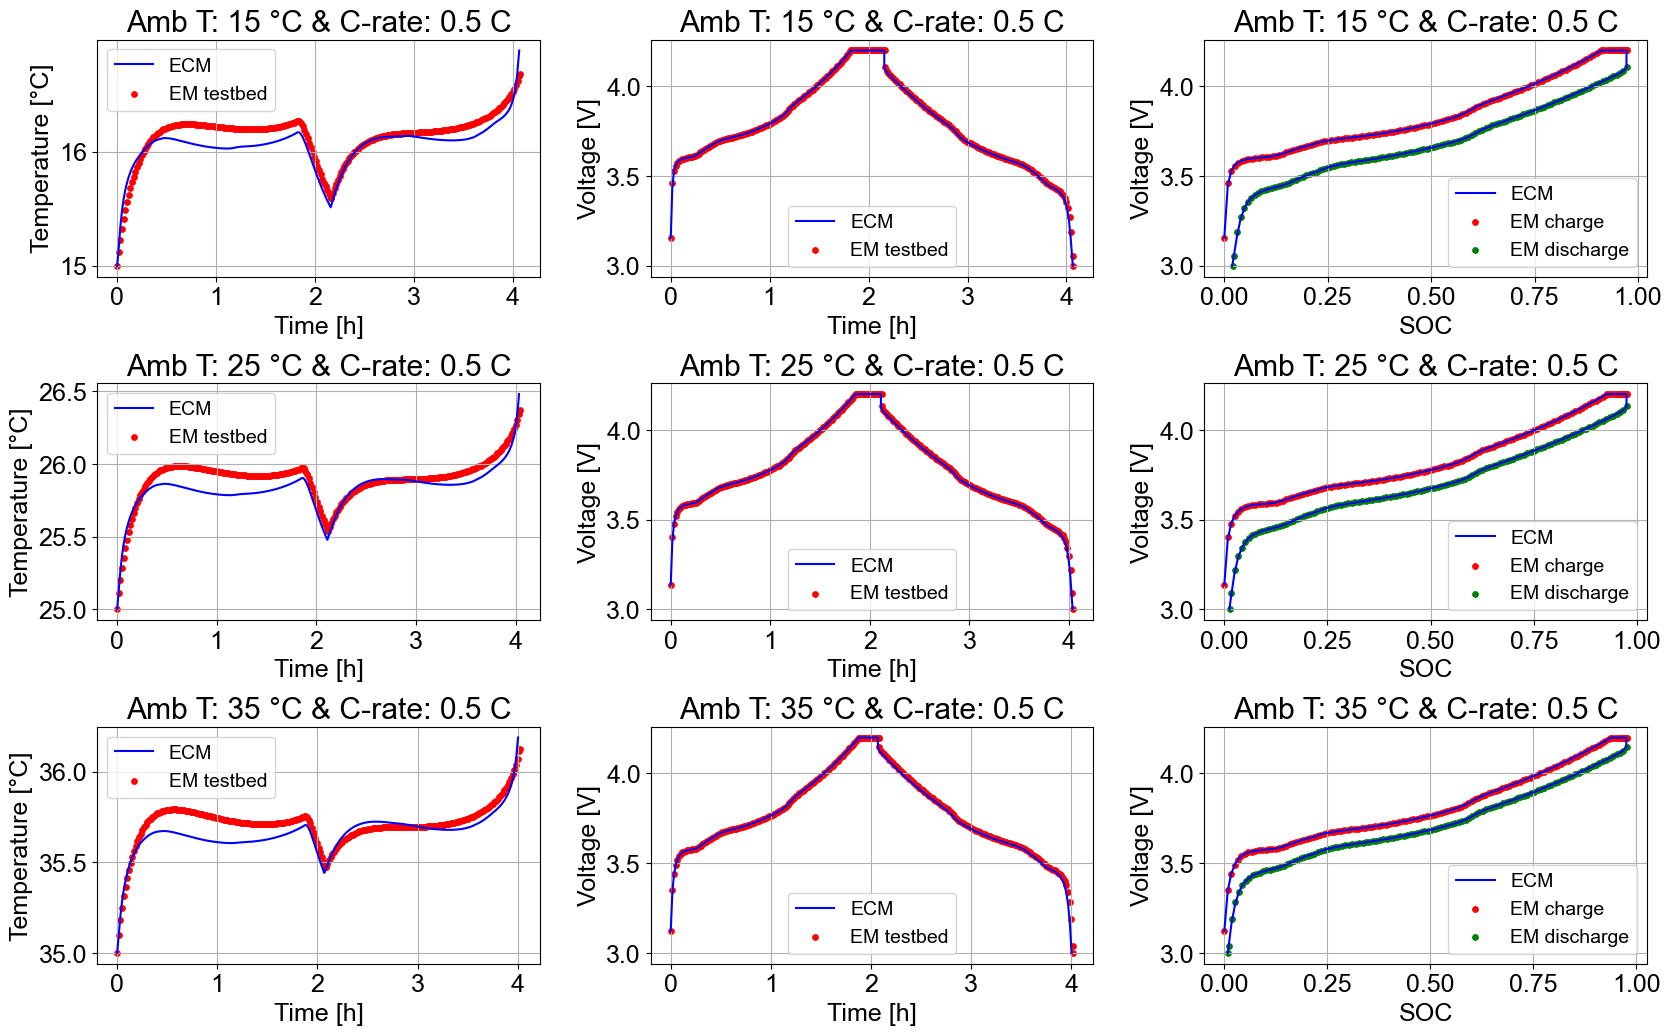

In [6]:
# current_C_candi = [0.5,1.5]
plt.rcParams['font.size'] = 18
current_A_candi = np.array(current_C_candi)*5

k_cell, cth_cell = np.array([0.1601733,173.6341749])
params.update(
    {   
        "Cell-jig heat transfer coefficient [W/K]": k_cell,
        "Cell thermal mass [J/K]": cth_cell,     
    }, check_already_exists = False
)
RMSE_T = []

for c, current_A in enumerate(current_A_candi[:1]):
    c_rate = current_A/5
    ecm_voltage_org = pd.read_csv(f'ecm_temperature_{c_rate}C.csv')
    experiment  = pybamm.Experiment([
    (
     f"Charge at {current_A}A until 4.2V",
     "Hold at 4.2V until C/20",
     f"Discharge at {current_A}A until 3.0V",
    )])
    for t, temperature_C in enumerate(temperature_C_candi):
        print(c_rate, temperature_C)
        ecm_voltage = ecm_voltage_org[(ecm_voltage_org['Temperature [degC]']==temperature_C)].reset_index(drop=True)   
        params.update(            
            {"Current function [A]": -current_A,
             "Initial temperature [K]": temperature_C + 273.15,     
             "Ambient temperature [K]": temperature_C + 273.15, })    
        sim = pybamm.Simulation(model,parameter_values=params,experiment=experiment,solver=solver)
        ecm_voltage_ch = ecm_voltage[(ecm_voltage['Current [A]']==-current_A)].reset_index(drop=True)   
        ecm_voltage_dch = ecm_voltage[(ecm_voltage['Current [A]']==current_A)].reset_index(drop=True) 

        sol = sim.solve()    
        dch_st_idx = discharge_st_index(sol['Current [A]'].entries) # Index starting decrease of SOC (discharge start)
        ch_ed_idx = dch_st_idx-1
        rmse_T = rmse_cal(ecm_voltage,sol,'Time [h]','Cell temperature [degC]')
        rmse_V = rmse_cal(ecm_voltage,sol,'Time [h]','Voltage [V]')
        rmse_V_SOC = rmse_cal_ch_dch(ecm_voltage_ch,ecm_voltage_dch,sol,'SoC','Voltage [V]',ch_ed_idx,dch_st_idx)
        RMSE_T.append(rmse_T)
        print(rmse_T,rmse_V,rmse_V_SOC)
        
        plt.figure(1,figsize=(20,4*3))
        plt.subplot(3,3,1+3*t+c)
        plt.grid()    
        plt.plot(sol['Time [h]'].entries, sol['Cell temperature [degC]'].entries,c='b',label='ECM')
        plt.scatter(ecm_voltage['Time [h]'],ecm_voltage['Cell temperature [degC]'],c='r',s=15,label='EM testbed')        
#         plt.scatter(ecm_voltage_ch['Time [h]'],ecm_voltage_ch['Cell temperature [degC]'],c='r',s=15,label='EM')
#         plt.scatter(ecm_voltage_dch['Time [h]'],ecm_voltage_dch['Cell temperature [degC]'],c='r',s=15)        
        plt.xlabel('Time [h]')
        plt.ylabel('Temperature [°C]')
        plt.title(f'Amb T: {temperature_C} °C & C-rate: {current_A/5} C')
        plt.legend(fontsize=14)

        plt.subplot(3,3,2+3*t+c)        
        plt.grid()
        plt.plot(sol['Time [h]'].entries, sol['Voltage [V]'].entries,c='b',label='ECM')
#         plt.scatter(ecm_voltage_ch['Time [h]'],ecm_voltage_ch['Voltage [V]'],c='r',s=15,label='EM')
#         plt.scatter(ecm_voltage_dch['Time [h]'],ecm_voltage_dch['Voltage [V]'],c='r',s=15)        
        plt.scatter(ecm_voltage['Time [h]'],ecm_voltage['Voltage [V]'],c='r',s=15,label='EM testbed')        
        plt.xlabel('Time [h]')
        plt.ylabel('Voltage [V]')
        plt.title(f'Amb T: {temperature_C} °C & C-rate: {current_A/5} C')
        plt.legend(fontsize=14)

        plt.subplot(3,3,3+3*t+c)        
        plt.grid()
        plt.plot(sol['SoC'].entries, sol['Voltage [V]'].entries,c='b',label='ECM')
        plt.scatter(ecm_voltage_ch['SoC'],ecm_voltage_ch['Voltage [V]'],c='r',s=15,label='EM charge')
        plt.scatter(ecm_voltage_dch['SoC'],ecm_voltage_dch['Voltage [V]'],c='g',s=15, label = 'EM discharge')        
        plt.xlabel('SOC')
        plt.ylabel('Voltage [V]')
        plt.title(f'Amb T: {temperature_C} °C & C-rate: {current_A/5} C')
        plt.legend(fontsize=14)
        plt.subplots_adjust(wspace=0.25,hspace=0.45)

plt.show()        


7.5
1.5 15
0.16629914144154553 0.022327469060673646 0.0014949185461989349
1.5 25
0.16178319819752363 0.028556521335729064 0.0011419660128433044
1.5 35
0.17866768059237761 0.03445075404299908 0.0008149016685213294


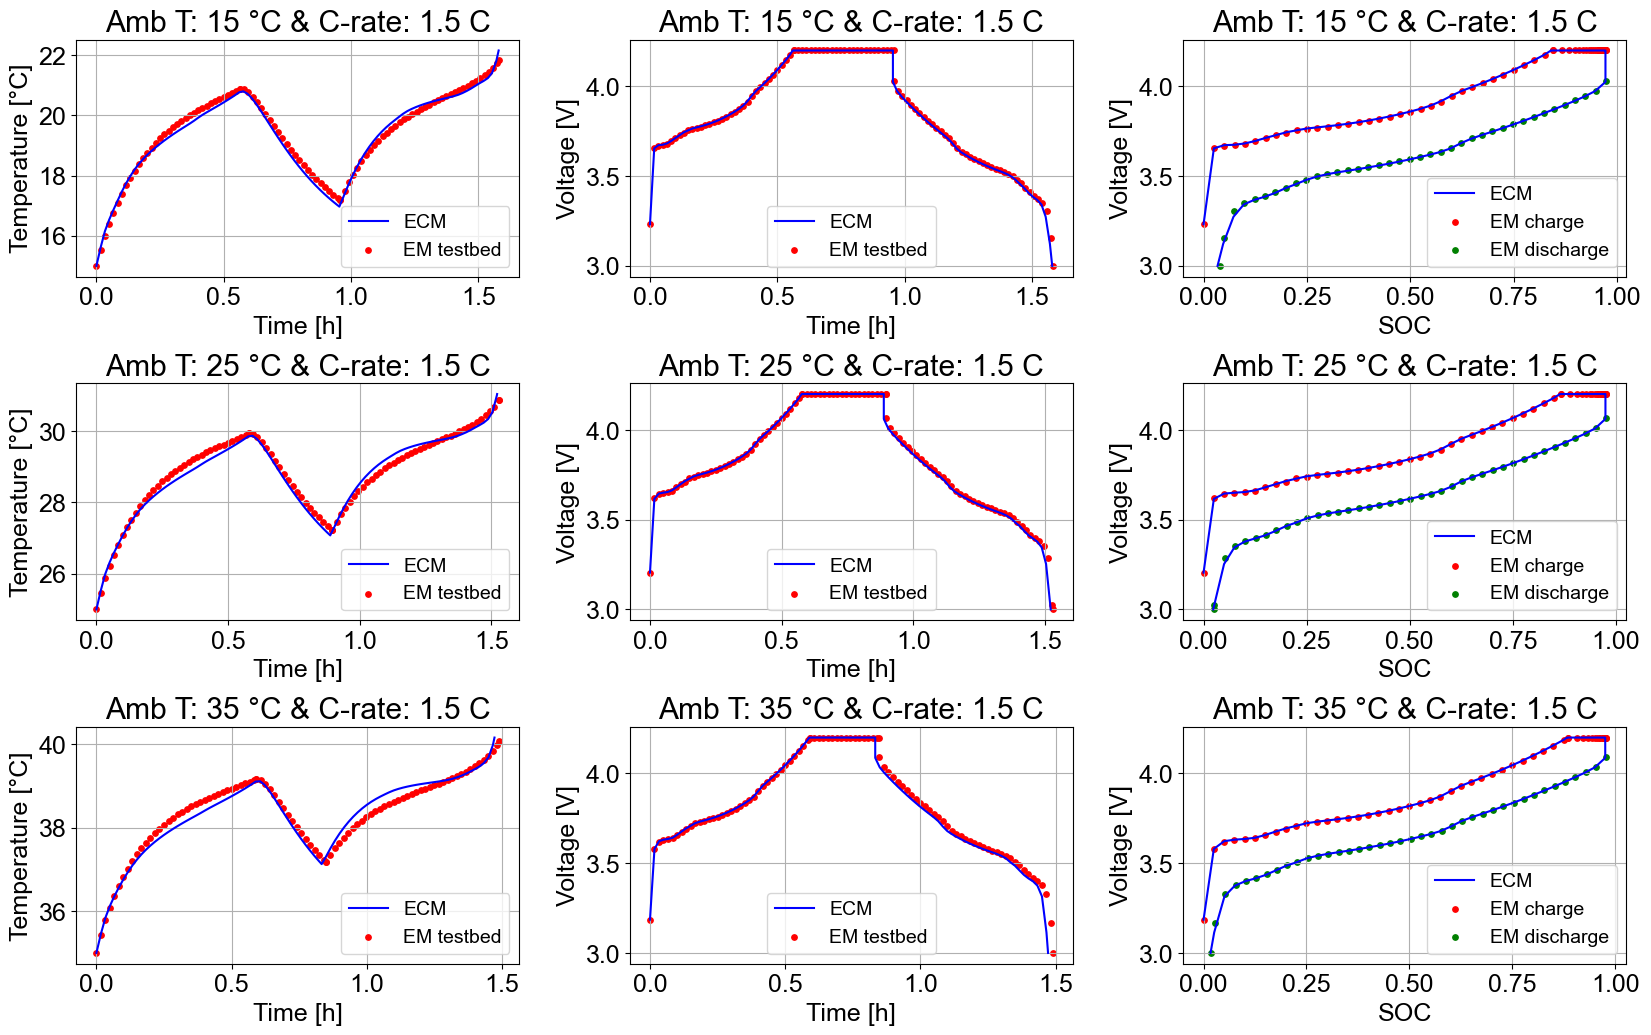

In [7]:
# current_C_candi = [0.5,1.5]
plt.rcParams['font.size'] = 18
current_A_candi = np.array(current_C_candi)*5

k_cell, cth_cell = np.array([0.1601733,173.6341749])
params.update(
    {   
        "Cell-jig heat transfer coefficient [W/K]": k_cell,
        "Cell thermal mass [J/K]": cth_cell,     
    }, check_already_exists = False
)
RMSE_T = []

for c, current_A in enumerate(current_A_candi[1:]):
    c_rate = current_A/5
    print(current_A)
    ecm_voltage_org = pd.read_csv(f'ecm_temperature_{c_rate}C.csv')
    experiment  = pybamm.Experiment([
    (
     f"Charge at {current_A}A until 4.2V",
     "Hold at 4.2V until C/20",
     f"Discharge at {current_A}A until 3.0V",
    )])
    for t, temperature_C in enumerate(temperature_C_candi):
        print(c_rate, temperature_C)
        ecm_voltage = ecm_voltage_org[(ecm_voltage_org['Temperature [degC]']==temperature_C)].reset_index(drop=True)   
        params.update(            
            {"Current function [A]": -current_A,
             "Initial temperature [K]": temperature_C + 273.15,     
             "Ambient temperature [K]": temperature_C + 273.15, })    
        sim = pybamm.Simulation(model,parameter_values=params,experiment=experiment,solver=solver)
        ecm_voltage_ch = ecm_voltage[(ecm_voltage['Current [A]']==-current_A)].reset_index(drop=True)   
        ecm_voltage_dch = ecm_voltage[(ecm_voltage['Current [A]']==current_A)].reset_index(drop=True) 

        sol = sim.solve()    
        dch_st_idx = discharge_st_index(sol['Current [A]'].entries) # Index starting decrease of SOC (discharge start)
        ch_ed_idx = dch_st_idx-1
        rmse_T = rmse_cal(ecm_voltage,sol,'Time [h]','Cell temperature [degC]')
        rmse_V = rmse_cal(ecm_voltage,sol,'Time [h]','Voltage [V]')
        rmse_V_SOC = rmse_cal_ch_dch(ecm_voltage_ch,ecm_voltage_dch,sol,'SoC','Voltage [V]',ch_ed_idx,dch_st_idx)
        RMSE_T.append(rmse_T)
        print(rmse_T,rmse_V,rmse_V_SOC)
        
        plt.figure(1,figsize=(20,4*3))
        plt.subplot(3,3,1+3*t+c)
        plt.grid()    
        plt.plot(sol['Time [h]'].entries, sol['Cell temperature [degC]'].entries,c='b',label='ECM')
        plt.scatter(ecm_voltage['Time [h]'],ecm_voltage['Cell temperature [degC]'],c='r',s=15,label='EM testbed')        
#         plt.scatter(ecm_voltage_ch['Time [h]'],ecm_voltage_ch['Cell temperature [degC]'],c='r',s=15,label='EM')
#         plt.scatter(ecm_voltage_dch['Time [h]'],ecm_voltage_dch['Cell temperature [degC]'],c='r',s=15)        
        plt.xlabel('Time [h]')
        plt.ylabel('Temperature [°C]')
        plt.title(f'Amb T: {temperature_C} °C & C-rate: {current_A/5} C')
        plt.legend(fontsize=14)

        plt.subplot(3,3,2+3*t+c)        
        plt.grid()
        plt.plot(sol['Time [h]'].entries, sol['Voltage [V]'].entries,c='b',label='ECM')
#         plt.scatter(ecm_voltage_ch['Time [h]'],ecm_voltage_ch['Voltage [V]'],c='r',s=15,label='EM')
#         plt.scatter(ecm_voltage_dch['Time [h]'],ecm_voltage_dch['Voltage [V]'],c='r',s=15)        
        plt.scatter(ecm_voltage['Time [h]'],ecm_voltage['Voltage [V]'],c='r',s=15,label='EM testbed')        
        plt.xlabel('Time [h]')
        plt.ylabel('Voltage [V]')
        plt.title(f'Amb T: {temperature_C} °C & C-rate: {current_A/5} C')
        plt.legend(fontsize=14)

        plt.subplot(3,3,3+3*t+c)        
        plt.grid()
        plt.plot(sol['SoC'].entries, sol['Voltage [V]'].entries,c='b',label='ECM')
        plt.scatter(ecm_voltage_ch['SoC'],ecm_voltage_ch['Voltage [V]'],c='r',s=15,label='EM charge')
        plt.scatter(ecm_voltage_dch['SoC'],ecm_voltage_dch['Voltage [V]'],c='g',s=15, label = 'EM discharge')        
        plt.xlabel('SOC')
        plt.ylabel('Voltage [V]')
        plt.title(f'Amb T: {temperature_C} °C & C-rate: {current_A/5} C')
        plt.legend(fontsize=14)
        plt.subplots_adjust(wspace=0.25,hspace=0.45)

plt.show()        


In [8]:
ecm_voltage_ch[['Time [h]','SoC','Voltage [V]']]

,Time [h],SoC,Voltage [V]
0,0.000000,0.000000,3.185077
1,0.016667,0.025000,3.581442
2,0.033333,0.050000,3.620434
3,0.050000,0.075000,3.630278
4,0.066667,0.100000,3.634373
5,0.083333,0.125000,3.640711
6,0.100000,0.150000,3.657609
7,0.116667,0.175000,3.676106
8,0.133333,0.200000,3.692117
9,0.150000,0.225000,3.708776


In [9]:
pd.DataFrame([sol.cycles[0].steps[1]['Time [h]'].entries, sol.cycles[0].steps[1]['SoC'].entries, sol.cycles[0].steps[1]['Voltage [V]'].entries]).transpose()

,0,1,2
0,0.588892,0.883338,4.2
1,0.605559,0.904649,4.2
2,0.622225,0.920366,4.2
3,0.638892,0.932325,4.2
4,0.655559,0.941638,4.2
5,0.672225,0.949023,4.2
6,0.688892,0.954965,4.2
7,0.705559,0.959794,4.2
8,0.722225,0.963702,4.2
9,0.738892,0.966813,4.2


In [10]:
print(np.mean(RMSE_T))

0.16891667341048225
